In [4]:
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline

def grid(n, prob):
    """
    Construct a grid with dimension n with probability prob
    """
    return np.random.choice([0, 1], size=(n, n), p=[prob, 1-prob])



In [2]:
def writing_data(samples, n, prob):
    """
    samples: number of samples (int)
    n: size of matrix  (odd int)
    prob: probability of getting 1 or 0 (0<=prob<=1)
    """
    count = 0.
    mat = []
    vd = np.zeros(samples)
    for ind in range(samples):
        b = grid(n, prob)
        mat.append(cp.copy(b)) #Used copy to not have 2 on the matrix
        b[(n-1)//2][(n-1)//2] = 2
        stop = False
        while not stop:
            change = False
            for i, j in zip(*np.where(b == 2)):
                if i == 0 or j == 0 or i == n - 1 or j == n - 1:
                    count += 1
                    stop = True
                    vd[ind] = 1
                    break
                if b[i+1, j] == 0:
                    b[i+1, j] = 2
                    change = True
                if b[i, j+1] == 0:
                    b[i, j+1] = 2
                    change = True
                if b[i-1, j] == 0:
                    b[i-1, j] = 2
                    change = True
                if b[i, j-1] == 0:
                    b[i, j-1] = 2
                    change = True
            if not change:
                stop = True
    return np.array(mat),vd

# Build a model

In this case I use a simple Neural Network with one input layer and one hidden layer with output 0 (if the matrix don't percolate) or 1 (if the matrix percolate).

In [ ]:
n = 15
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(n, n)),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Make the Training data

In [ ]:
#traning data
td,tr = writing_data(1000,n,0.5)

# Show sample of data

In [ ]:
plt.imshow(td[0])
print(tr[0])

# Training the model

In [ ]:
history = model.fit(td,tr, epochs = 12)

# Testing the model

In [ ]:
test_mat,test_v = writing_data(100,n,0.6)
test_loss, test_acc = model.evaluate(test_mat, test_v)
print('Test accuracy:', test_acc)

# Plotting the probability versus the accuracy of the method

We have a plot that shows that the accuracy decreases on the critical probability for the model.

The way to acquire data for the plot is given in the line below the plot

In [ ]:
plt.plot(probability,acc, 'o')
plt.show()

In [ ]:
probability = np.linspace(0.,1.,100)
acc = np.zeros(len(probability))
for i,v in enumerate(probability):
    #test data
    test_mat,test_v = writing_data(100,n,v)
    #evaluate accuracy
    test_loss, test_acc = model.evaluate(test_mat, test_v)
    acc[i] = test_acc

# Building another model

This time I will use Convolutional Neural Networks with 1 convolutional + pooling layers before entering the Neural Network structure that is the same as the previous one. We have chosen the probability to be 0.5 in order to have the same number of samples that percolates and that doesn't percolate.

In [70]:
#traning data
n = 15 #Number of samples
td,tr = writing_data(10000,n,0.5)
td = td.reshape(-1,n,n,1)
#One hot encoding
tr = keras.utils.to_categorical(tr, num_classes= 2)
#Splitting data
train_x , test_x , train_y , test_y = train_test_split(td , tr , 
                                            test_size = 0.2 ,
                                            random_state = 42)

In [91]:
model = keras.Sequential([
    keras.layers.Conv2D(50, kernel_size= 2, activation=tf.nn.relu, input_shape=(n,n,1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax),
])
model.compile(optimizer='adam', 
              loss= keras.losses.kullback_leibler_divergence,
              metrics=['accuracy'])

In [92]:
#Callbacks
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', 
                                         histogram_freq= 1, 
                                         write_graph= True, 
                                         write_images= True,
                                        update_freq= 'batch')

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          min_delta=0.001,
                                          patience=7, 
                                          verbose=2, 
                                          mode='min')

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

callbacks = [earlystop,tbCallBack, reduce_lr]

In [93]:
history = model.fit(train_x,
                    train_y, 
                    epochs = 20,
                    batch_size=512,
                    verbose = 2,
                    validation_data=(test_x, test_y),
                    callbacks = callbacks
                   )

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
 - 6s - loss: 1.1141 - acc: 0.4942 - val_loss: 0.6928 - val_acc: 0.4860
Epoch 2/20
 - 6s - loss: 0.6912 - acc: 0.5454 - val_loss: 0.6870 - val_acc: 0.5410
Epoch 3/20
 - 6s - loss: 0.6817 - acc: 0.5485 - val_loss: 0.6747 - val_acc: 0.6965
Epoch 4/20
 - 6s - loss: 0.6725 - acc: 0.5981 - val_loss: 0.6649 - val_acc: 0.5815
Epoch 5/20
 - 6s - loss: 0.6534 - acc: 0.6607 - val_loss: 0.6467 - val_acc: 0.6890
Epoch 6/20
 - 7s - loss: 0.6313 - acc: 0.7019 - val_loss: 0.6226 - val_acc: 0.7075
Epoch 7/20
 - 7s - loss: 0.6050 - acc: 0.7072 - val_loss: 0.5983 - val_acc: 0.7055
Epoch 8/20
 - 8s - loss: 0.5795 - acc: 0.7126 - val_loss: 0.5758 - val_acc: 0.7105
Epoch 9/20
 - 8s - loss: 0.5586 - acc: 0.7134 - val_loss: 0.5624 - val_acc: 0.7110
Epoch 10/20
 - 7s - loss: 0.5448 - acc: 0.7201 - val_loss: 0.5536 - val_acc: 0.7160
Epoch 11/20
 - 7s - loss: 0.5370 - acc: 0.7200 - val_loss: 0.5571 - val_acc: 0.7105
Epoch 12/20
 - 7s - loss: 0.5292 - ac

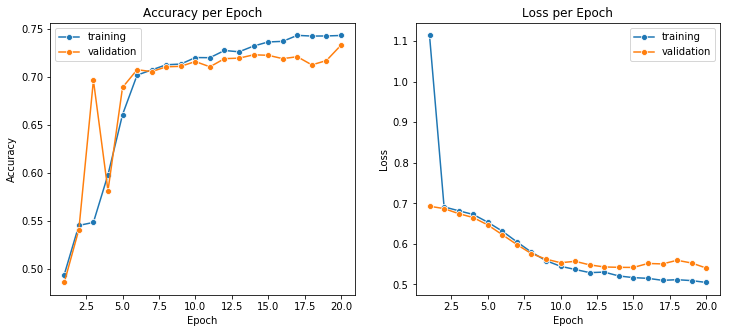

In [94]:
#accuracy
train_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

#loss 
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

#Epochs
epoch_range = range(1,len(train_accuracy)+1)

#Plot
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].set_title('Accuracy per Epoch')
sns.lineplot(x=epoch_range,y=train_accuracy,marker='o',ax=ax[0])
sns.lineplot(x=epoch_range,y=validation_accuracy,marker='o',ax=ax[0])
ax[0].legend(['training','validation'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[1].set_title('Loss per Epoch')
sns.lineplot(x=epoch_range,y=train_loss,marker='o',ax=ax[1])
sns.lineplot(x=epoch_range,y=validation_loss,marker='o',ax=ax[1])
ax[1].legend(['training','validation'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

# Plotting the order parameter

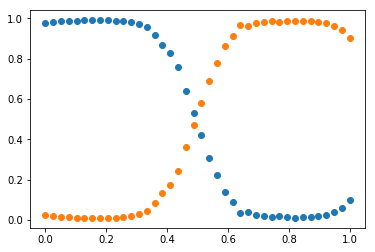

In [103]:
probability = np.linspace(0.,1.,40)
P_1 = np.zeros(len(probability))
P_2 = np.zeros(len(probability))
for i,v in enumerate(probability):
    #test data
    test_mat,test_v = writing_data(100,n,v)
    test_mat = test_mat.reshape(-1,n,n,1)     
    a = model.predict(test_mat)
    o_1 = []
    o_2 = []
    for samp in a:
        o_1.append(samp[0])
        o_2.append(samp[1])
    P_1[i] = np.mean(o_1)
    P_2[i] = np.mean(o_2)
    
q = plt.plot(probability, P_1, 'o')
q = plt.plot(probability, P_2, 'o')

# Plotting the probability versus the accuracy of the method

We have a plot that shows that the accuracy decreases on the critical probability for the model.

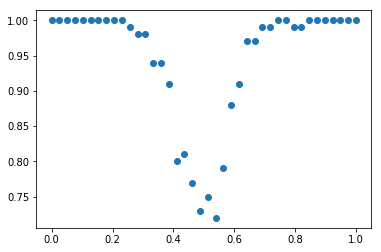

In [104]:
probability = np.linspace(0.,1.,40)
acc = np.zeros(len(probability))
for i,v in enumerate(probability):
    #test data
    test_mat,test_v = writing_data(100,n,v)
    test_mat = test_mat.reshape(-1,n,n,1) 
    test_v = keras.utils.to_categorical(test_v, num_classes= 2) #One Hot Encoding
    #evaluate accuracy
    test_loss, test_acc = model.evaluate(test_mat, test_v, verbose = 0)
    acc[i] = test_acc

q = plt.plot(probability,acc, 'o')

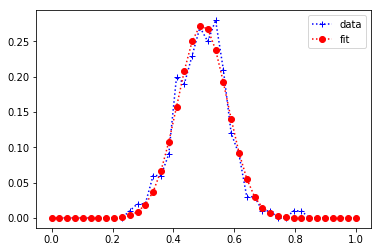

In [105]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
x = probability
y = 1 - acc

popt,pcov = curve_fit(gaus,x,y, p0=[0.5,0.3,1.])
plt.plot(x,y,'b+:',label='data')
plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.legend()
plt.show()

Adjusting a Gaussian we can find the percolation probability.

In [106]:
print("Percolation probability:%.5f" % popt[1])

Percolation probability:0.49578


# Finite Size Scaling